In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

START_DATE = "2015-01-01"
END_DATE   = "2025-12-12"

hsi_stocks = pd.read_excel("/Users/henrywzh/Desktop/hk_stock_ejfq.xlsx")

def code_int_to_hk(code: int) -> str:
    return f"{int(code):04d}.HK"

UNIVERSE = hsi_stocks["代码"].apply(code_int_to_hk).tolist()

price_df = yf.download(UNIVERSE, START_DATE, END_DATE, auto_adjust=False, group_by="column")
hsi = yf.download("^HSI", START_DATE, END_DATE, auto_adjust=False)

# Extract close matrices
close = price_df["Close"].sort_index()
hsi_close = hsi["Close"].sort_index()

# Common calendar (optional but recommended)
common_dates = close.index.intersection(hsi_close.index)
close = close.loc[common_dates]
hsi_close = hsi_close.loc[common_dates]

[*********************100%***********************]  108 of 108 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
from research.backtest import TRADING_DAYS
import matplotlib.pyplot as plt

In [10]:
def top_n_backtest(
    price_df: pd.DataFrame,
    signal: pd.DataFrame,
    top_n: int = 10,
    H: int = 5,
    entry_mode: str = "next_close",
    costs_bps: float = 0.0,
    min_assets: int = 50,
) -> dict:
    """
    Rank universe by signal at each rebalance date, hold equal-weight top N.

    Conventions
    ----------
    - signal observed at close[t]
    - enter at t+1 using:
        - next_close: close-to-close return from t->t+1 (approx)
        - next_open : open-to-open return from t->t+1
    - rebalance every H days (non-overlapping formation dates)

    Parameters
    ----------
    price_df : DataFrame
        yfinance-style columns. If multi-asset, expects price_df['Close'] as (T,N).
    signal : DataFrame
        dates x tickers, aligned to price_df prices
    top_n : int
        number of names to hold
    H : int
        rebalance frequency in trading days
    entry_mode : str
        "next_close" or "next_open"
    costs_bps : float
        round-trip-ish cost proxy per unit turnover (bps)
    min_assets : int
        require at least this many valid names to trade

    Returns
    -------
    dict with:
      - port_ret_gross, port_ret_net (Series)
      - weights (DataFrame weights on rebalance dates, ffilled between rebalances)
      - turnover (Series)
      - n_hold (Series)
      - coverage (Series, valid / total)
      - benchmark_equal_weight (Series) [optional helper]
    """
    if entry_mode not in {"next_close", "next_open"}:
        raise ValueError("entry_mode must be 'next_close' or 'next_open'")
    if top_n <= 0:
        raise ValueError("top_n must be positive")
    if H <= 0:
        raise ValueError("H must be positive")

    # Prices
    if entry_mode == "next_close":
        px = price_df["Close"].sort_index()
    else:
        px = price_df["Open"].sort_index()

    # Forward 1-day return aligned to formation date t
    ret_fwd_1d = px.pct_change(fill_method=None).shift(-1)

    # Align signal
    signal = signal.reindex(px.index).reindex(px.columns, axis=1)

    dates = px.index
    rebal_dates = dates[::H]

    weights_rebal = []
    out_dates = []
    n_hold = []
    coverage = []

    for t in rebal_dates:
        if t not in signal.index:
            continue

        sig_t = signal.loc[t]
        px_t = px.loc[t]

        valid = sig_t.notna() & px_t.notna()
        valid_names = sig_t.index[valid]
        n_valid = int(valid.sum())

        coverage.append(n_valid / len(sig_t) if len(sig_t) else np.nan)

        if n_valid < max(min_assets, top_n):
            # not enough names to form portfolio
            continue

        sig_valid = sig_t[valid_names]

        # Higher signal -> higher rank (top)
        top_names = sig_valid.sort_values(ascending=False).head(top_n).index

        w = pd.Series(0.0, index=sig_t.index)
        w.loc[top_names] = 1.0 / top_n

        weights_rebal.append(w)
        out_dates.append(t)
        n_hold.append(int((w > 0).sum()))

    if len(out_dates) == 0:
        raise ValueError("No rebalance dates produced a valid portfolio. Check min_assets/top_n/signal coverage.")

    w_rebal = pd.DataFrame(weights_rebal, index=out_dates)
    # Hold weights constant between rebalances
    w_daily = w_rebal.reindex(dates).ffill().fillna(0.0)

    # Portfolio gross return each day uses weights decided at t-1 close (no look-ahead)
    # Since weights are formed on close[t] and applied from t+1, shift weights by 1 day.
    w_exec = w_daily.shift(1).fillna(0.0)

    port_ret_gross = (w_exec * ret_fwd_1d).sum(axis=1)

    # Turnover: 0.5 * sum(|w_t - w_{t-1}|) is common definition (one-way turnover)
    dw = w_exec.diff().abs()
    turnover = 0.5 * dw.sum(axis=1).fillna(0.0)

    cost = (costs_bps / 10000.0) * turnover
    port_ret_net = port_ret_gross - cost

    # Some diagnostics series
    n_hold_s = pd.Series(n_hold, index=out_dates).reindex(dates).ffill()
    cov_s = pd.Series(coverage, index=rebal_dates[:len(coverage)]).reindex(dates).ffill()

    # Optional benchmark: equal-weight universe (on same execution convention)
    ew = pd.Series(1.0 / px.shape[1], index=px.columns)
    bench_ew = (ret_fwd_1d * ew).sum(axis=1)

    return {
        "port_ret_gross": port_ret_gross,
        "port_ret_net": port_ret_net,
        "weights_rebal": w_rebal,
        "weights_daily": w_daily,
        "turnover": turnover,
        "cost": cost,
        "n_hold": n_hold_s,
        "coverage": cov_s,
        "benchmark_ew": bench_ew,
        "meta": {
            "top_n": top_n,
            "H": H,
            "entry_mode": entry_mode,
            "costs_bps": costs_bps,
        }
    }

def perf_summary(r: pd.Series, freq: float = TRADING_DAYS) -> dict:
    r = r.dropna()
    if len(r) < 2:
        return {"ann_return_geo": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_dd": np.nan, "n_obs": int(len(r))}

    eq = (1.0 + r).prod()
    ann_ret = float(eq ** (freq / len(r)) - 1.0)
    ann_vol = float(r.std(ddof=1) * np.sqrt(freq))
    sharpe = float((r.mean() * freq) / ann_vol) if ann_vol > 0 else np.nan

    eq_curve = (1.0 + r).cumprod()
    dd = eq_curve / eq_curve.cummax() - 1.0
    max_dd = float(dd.min())

    return {"ann_return_geo": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": max_dd, "n_obs": int(len(r))}



In [11]:
def cs_winsorize_zscore(sig: pd.DataFrame, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.DataFrame:
    def _proc_row(x: pd.Series) -> pd.Series:
        m = x.notna()
        if m.sum() < 10:
            return x
        lo = x[m].quantile(lower_q)
        hi = x[m].quantile(upper_q)
        x2 = x.copy()
        x2[m] = x[m].clip(lo, hi)
        mu = x2[m].mean()
        sd = x2[m].std(ddof=1)
        if sd == 0 or not np.isfinite(sd):
            return x2
        x2[m] = (x2[m] - mu) / sd
        return x2

    return sig.apply(_proc_row, axis=1)


def build_rsi_universe(price_df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    close = price_df["Close"].sort_index()
    delta = close.diff()

    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi  # higher RSI = stronger


def build_macd_hist_universe(price_df: pd.DataFrame, fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
    close = price_df["Close"].sort_index()

    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()

    macd_line = ema_fast - ema_slow
    macd_sig = macd_line.ewm(span=signal, adjust=False, min_periods=signal).mean()
    macd_hist = macd_line - macd_sig
    return macd_hist  # positive = bullish momentum

In [14]:
TOP_N = 10
H = 2
ENTRY_MODE = 'next_close'
COST_BPS = 0.0

RSI TopN net: {'ann_return_geo': 0.20951297637079436, 'ann_vol': 0.26805191050336613, 'sharpe': 0.8442938786634797, 'max_dd': -0.45204749531231725, 'n_obs': 2697}
MACD TopN net: {'ann_return_geo': 0.04172379010655325, 'ann_vol': 0.28177806591483895, 'sharpe': 0.2864410023839257, 'max_dd': -0.6156404437381056, 'n_obs': 2697}
Benchmark EW: {'ann_return_geo': 0.08935613496512129, 'ann_vol': 0.21397631139407752, 'sharpe': 0.5072547048655425, 'max_dd': -0.46522650339599936, 'n_obs': 2697}
RSI turnover mean: 0.17615869484612534
MACD turnover mean: 0.13733778272154246


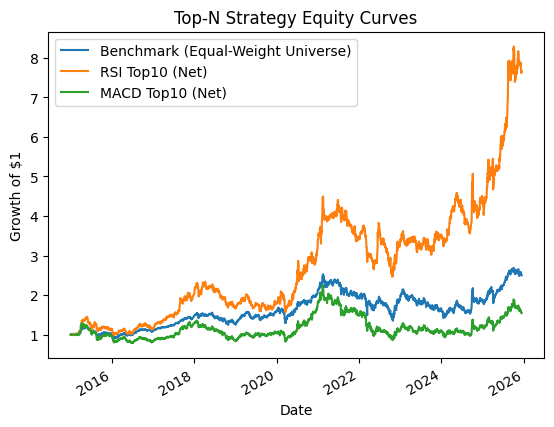

In [15]:
# 1) Build raw signals
sig_rsi = build_rsi_universe(price_df, period=14)
sig_macd = build_macd_hist_universe(price_df, fast=12, slow=26, signal=9)

# 2) Normalize cross-sectionally (recommended)
sig_rsi_z = cs_winsorize_zscore(sig_rsi)
sig_macd_z = cs_winsorize_zscore(sig_macd)

# 3) Backtest Top-N
res_rsi = top_n_backtest(
    price_df=price_df,
    signal=sig_rsi_z,
    top_n=TOP_N,
    H=H,
    entry_mode=ENTRY_MODE,
    costs_bps=COST_BPS,
    min_assets=50,
)

res_macd = top_n_backtest(
    price_df=price_df,
    signal=sig_macd_z,
    top_n=TOP_N,
    H=H,
    entry_mode=ENTRY_MODE,
    costs_bps=COST_BPS,
    min_assets=50,
)

# 4) Build equity curves
eq_rsi = (1.0 + res_rsi["port_ret_net"].fillna(0.0)).cumprod()
eq_macd = (1.0 + res_macd["port_ret_net"].fillna(0.0)).cumprod()
eq_bench = (1.0 + res_rsi["benchmark_ew"].fillna(0.0)).cumprod()  # same benchmark universe

# 5) Print stats
freq = TRADING_DAYS  # daily returns in this setup
print("RSI TopN net:", perf_summary(res_rsi["port_ret_net"], freq=freq))
print("MACD TopN net:", perf_summary(res_macd["port_ret_net"], freq=freq))
print("Benchmark EW:", perf_summary(res_rsi["benchmark_ew"], freq=freq))

print("RSI turnover mean:", float(res_rsi["turnover"].mean()))
print("MACD turnover mean:", float(res_macd["turnover"].mean()))

# 6) Plot equity curves
plt.figure()
eq_bench.plot(label="Benchmark (Equal-Weight Universe)")
eq_rsi.plot(label=f"RSI Top{TOP_N} (Net)")
eq_macd.plot(label=f"MACD Top{TOP_N} (Net)")
plt.title("Top-N Strategy Equity Curves")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()